#### 0.Setting & Function 

In [1]:
# 초기셋팅
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import datetime as dt

In [67]:
df_1 = pd.read_csv('C:/Users/mi-bi/OneDrive/바탕 화면/data Row/5years_kospi.csv', index_col=0)
df_2 = pd.read_csv('C:/Users/mi-bi/OneDrive/바탕 화면/data Row/5years_kosdaq.csv', index_col=0)
df_raw = pd.concat([df_1,df_2],ignore_index=True)

In [71]:
df_mom = pd.read_csv('C:/Users/mi-bi/OneDrive/바탕 화면/data Row/mom.csv', index_col=0)

In [72]:
''' Market Timming 을 만드는 함수 '''
''' Market Timing True 인경우 매매'''
def making_mt(start,end,code):
    from pykrx import stock
    df = stock.get_index_fundamental(start,end,code)
    
    ''' code : KOSPI ('1001') KOSDAQ ('2001') '''
    if code=='1001': 
        df['sma20'] = df['종가'].rolling(20).mean()
        df['mt'] = df['종가']>df['sma20']
        df = df.dropna()
        return df
    elif code=='2001':     
        df['sma3'] = df['종가'].rolling(3).mean()
        df['sma5'] = df['종가'].rolling(5).mean()
        df['sma10'] = df['종가'].rolling(10).mean()
        df['mt'] = ((df['종가']>df['sma3'])|(df['종가']>df['sma5'])|(df['종가']>df['sma10']))
        df = df.dropna()
        return df
    else:
        print('올바른 종목 code 입력')

In [73]:
''' graph '''
def making_mt_plot(df,code):
    import matplotlib.pyplot as plt
    from matplotlib import dates
    if code=='1001': 
        plt.figure(figsize = (50, 10))
        plt.title("Kospi Market timming")
        plt.plot(df["종가"])
        plt.plot(df['sma20'])
        plt.scatter(df.loc[df['mt']==1].index, df['종가'][df['mt']==1],
                    color = 'red',
                    label='Go',
                    marker ='^',
                    alpha=0.8)
        plt.scatter(df.loc[df['mt']==0].index, df['종가'][df['mt']==0],
                    color = 'blue',
                    label='Stop',
                    marker ='v',
                    alpha=0.8)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
    elif code=='2001':
        plt.figure(figsize = (50, 10))
        plt.title("Kosdaq Market timming")
        plt.plot(df["종가"])
        plt.plot(df['sma3'])
        plt.plot(df['sma5'])
        plt.plot(df['sma10'])
        plt.scatter(df.loc[df['mt']==1].index, df['종가'][df['mt']==1],
                    color = 'red',
                    label='Go',
                    marker ='^',
                    alpha=0.8)
        plt.scatter(df.loc[df['mt']==0].index, df['종가'][df['mt']==0],
                    color = 'blue',
                    label='Stop',
                    marker ='v',
                    alpha=0.8)
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
    else:
        print('Error : Code check')
    

In [74]:
''' 누적거래대금 조회 filter 함수 '''
def search_vol(df,date,range):
    df = df[(df['누적거래대금']>=range)&(df['날짜']==date)]
    return df

In [75]:
'''raw_df 를 받아서 momentum 지수(5 10 20) 를 만드는 함수 '''
def make_momentum(df):
    object_list = df['종목명'].unique()
    for i in object_list:
        idx = df[df['종목명']==i].index
        df.loc[idx[0]:idx[-1], '5_mom'] = df.loc[idx[0]:idx[-1],'종가']/df.loc[idx[0]:idx[-1],'종가'].shift(5)*100
        df.loc[idx[0]:idx[-1], '10_mom'] = df.loc[idx[0]:idx[-1],'종가']/df.loc[idx[0]:idx[-1],'종가'].shift(10)*100
        df.loc[idx[0]:idx[-1], '20_mom'] = df.loc[idx[0]:idx[-1],'종가']/df.loc[idx[0]:idx[-1],'종가'].shift(20)*100
        
    return df

In [76]:
'''모멘텀 파일 받아서 signal 을만들어주는 함수'''
def make_signal(df):
    object_list = df['종목명'].unique()
    for i in object_list:
        idx = df[df['종목명']==i].index
        con1=(df.loc[idx[0]:idx[-1],'5_mom'].shift(2)<100)&(df.loc[idx[0]:idx[-1],'5_mom'].shift(2)>=95)
        con2=(df.loc[idx[0]:idx[-1],'5_mom'].shift(1)>=100)&(df.loc[idx[0]:idx[-1],'5_mom'].shift(1)<110)
        con3=(df.loc[idx[0]:idx[-1],'5_mom']>=df.loc[idx[0]:idx[-1],'5_mom'].shift(1))&(df.loc[idx[0]:idx[-1],'5_mom']<110)
        df.loc[idx[0]:idx[-1], 'signal'] = con1&con2&con3
    return df

In [77]:
'Market Timming 과 날짜 통일화 '
def raw_df_date(df):
    df['날짜'] = df['날짜'].astype('str')
    df['날짜'] = pd.to_datetime(df['날짜'], format='%Y%m%d')

In [263]:
def backtest_result(portfolio):
    result = pd.DataFrame(columns=['날짜','매수총합','매도총합','수익금','수익률'])
    count = 0
    for i in portfolio['날짜'].unique():
        buy = portfolio[portfolio['날짜']==i]['종가'].sum()
        sell= portfolio[portfolio['날짜']==i]['5일후_종가'].sum()
        profits = sell-buy
        revenue = profits/buy*100
        li = [i,buy,sell,profits,revenue]
        result.loc[count] = li
        count += 1
    return result

#### 1.Sequantial 

In [68]:
df_mom = make_momentum(df_raw)

In [79]:
start = df_mom['날짜'].unique().min()
end = df_mom['날짜'].unique().max()
print(start,'~',end)

2018-01-29 ~ 2022-12-29


In [80]:
df_kospi_mt = making_mt(start,end,'1001')
df_kosdaq_mt = making_mt(start,end,'2001')

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.


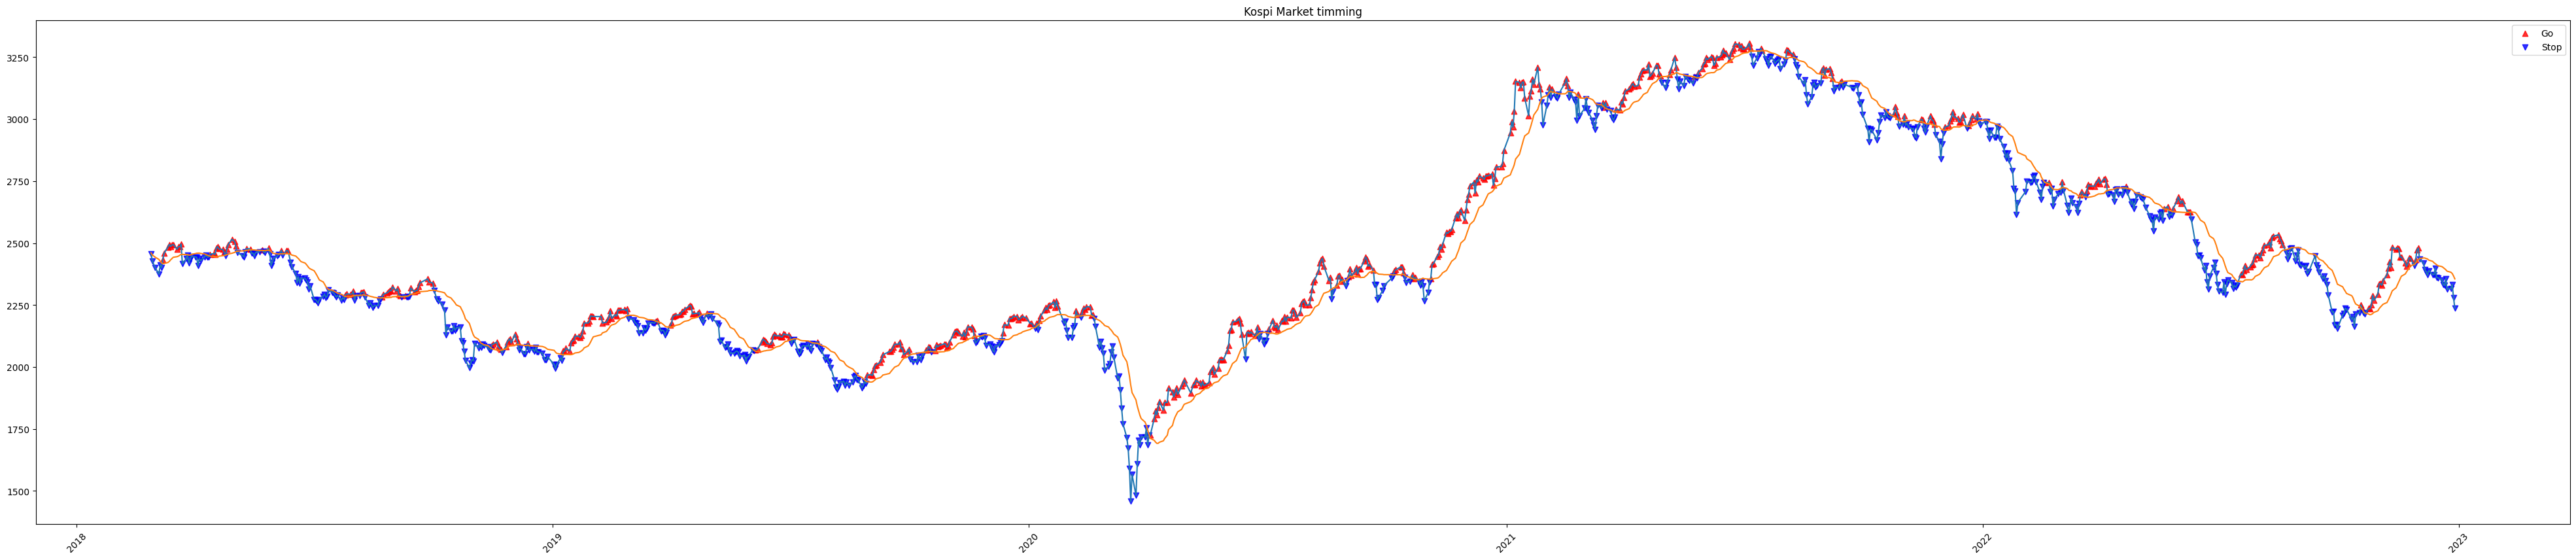

In [81]:
making_mt_plot(df_kospi_mt,'1001')

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.


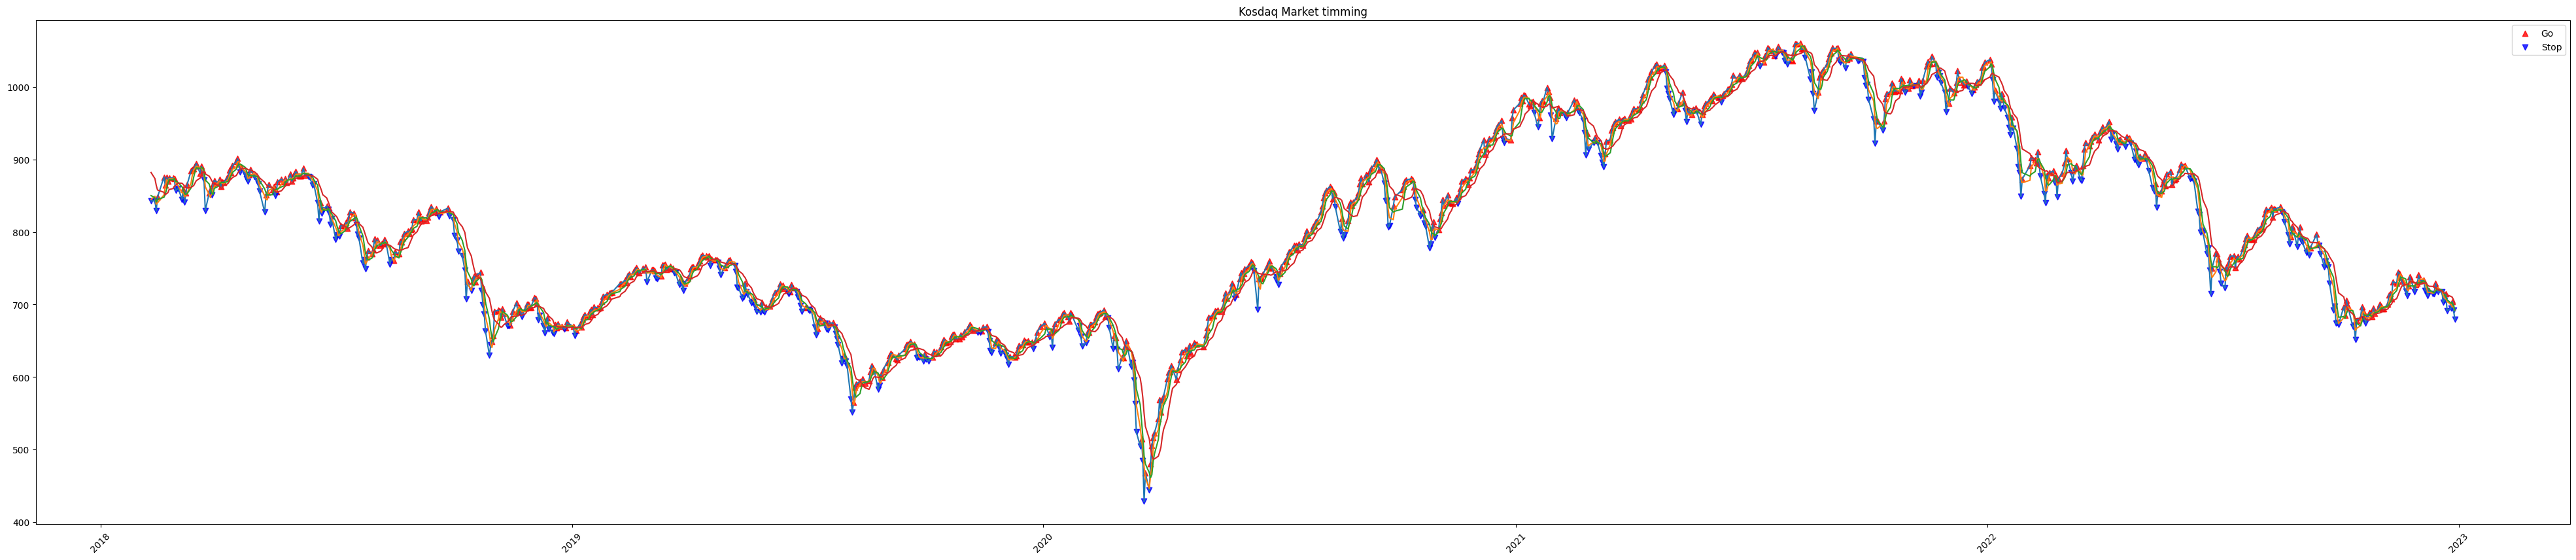

In [82]:
making_mt_plot(df_kosdaq_mt,'2001')

In [83]:
df_mom['날짜'] = df_mom['날짜'].astype('str')
df_mom['날짜'] = pd.to_datetime(df_mom['날짜'], format='%Y%m%d')
df_mom.info()

ValueError: time data '2022-12-22' does not match format '%Y%m%d' (match)

#### Strategy 1 <모멘텀 상승초입에 진입하여 3일뒤 시가에 매도>  
1. {Kosdaq_mt} == True  
2. {거래대금} >= 10,000,000,000  
3. {momentum : 5일} signal True 매수후 +3일뒤 시가에 매도  
2일전{momentum} <100 and >95  
1일전{momentum} >=100 and <110(급등주 쫒기 방지)  
당일{momenutm} >= 1일전{momentum} and <110(급등주 쫒기 방지)   



In [84]:
df_kosdaq_mt = df_kosdaq_mt.reset_index()

In [87]:
df_mom = make_signal(df_mom)

In [59]:
def plot_signal(df):
    plt.figure(figsize = (50, 10))
    plt.title("삼성전자 momentum")
    plt.plot(df["종가"])
    plt.scatter(df.loc[df['signal']==True].index, df['종가'][df['signal']==True],
                color = 'red',
                label='Go',
                marker ='^',
                alpha=0.8)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    

In [94]:
def make_5_return(df):
    object_list = df['종목명'].unique()
    for i in object_list:
        idx = df[df['종목명']==i].index
        df.loc[idx[0]:idx[-1], '5일후_종가'] = df.loc[idx[0]:idx[-1],'종가'].shift(-5)
    return df

In [95]:
make_5_return(df_mom)

,날짜,종가,시가,최고가,최저가,누적거래량,누적거래대금,종목명,5_mom,10_mom,20_mom,signal,5일후_종가
0,2022-12-22,10650,9980,11700,9930,28856232,309808795730,바이오노트,NaN,NaN,NaN,False,8580.0
1,2022-12-23,10150,10600,11200,10100,8180753,86595242100,바이오노트,NaN,NaN,NaN,False,NaN
2,2022-12-26,9720,10550,10700,9650,4479667,45206813740,바이오노트,NaN,NaN,NaN,False,NaN
3,2022-12-27,9360,9770,9880,9130,4101930,38365054640,바이오노트,NaN,NaN,NaN,False,NaN
4,2022-12-28,8870,9390,9420,8700,3177379,28837782380,바이오노트,NaN,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621629,2022-12-23,3765,3900,3900,3765,33477,127543190,모헨즈,95.195954,94.007491,93.077874,False,NaN
2621630,2022-12-26,3720,3765,3765,3610,30218,111265525,모헨즈,93.820933,95.140665,95.019157,False,NaN
2621631,2022-12-27,3755,3700,3755,3665,17856,66261900,모헨즈,100.133333,91.697192,92.487685,False,NaN
2621632,2022-12-28,3630,3770,3775,3615,25279,93477675,모헨즈,95.275591,87.787183,88.000000,False,NaN


In [109]:
df_kosdaq_mt['날짜'][:3]

0   2018-02-09
1   2018-02-12
2   2018-02-13
Name: 날짜, dtype: datetime64[ns]

In [105]:
df_kosdaq_mt['날짜'].unique()[:1]

array(['2018-02-09T00:00:00.000000000'], dtype='datetime64[ns]')

In [106]:
df_mom['날짜'].unique()[:1]

array(['2022-12-22'], dtype=object)

In [127]:
mt = df_kosdaq_mt[df_kosdaq_mt['mt']==True]

In [139]:
mt['날짜'] = mt['날짜'].astype(str)

C:\Users\mi-bi\AppData\Local\Temp\ipykernel_27192\298300344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mt['날짜'] = mt['날짜'].astype(str)


In [200]:
def make_portfolio(mt,df):
    portfolio = pd.DataFrame()
    for i in mt['날짜']:
        vol = search_vol(df,i,10000000000)
        result = vol[vol['signal']==True]
        portfolio = pd.concat([portfolio,result])
    return portfolio()

In [236]:
def backtest_result(portfolio):
    result = pd.DataFrame(columns=['날짜','매수총합','매도총합','수익금','수익률'])
    count = 0
    for i in portfolio['날짜'].unique():
        buy = portfolio[portfolio['날짜']==i]['종가'].sum()
        sell= portfolio[portfolio['날짜']==i]['5일후_종가'].sum()
        profits = sell-buy
        revenue = profits/buy*100
        li = [i,buy,sell,profits,revenue]
        result.loc[count] = li
        count += 1
    return result

In [237]:
result = backtest_result(portfolio)

In [246]:
result

,날짜,매수총합,매도총합,수익금,수익률
0,2018-02-14,649297,682253.0,32956.0,5.075643
1,2018-02-19,2905916,2970616.0,64700.0,2.226492
2,2018-02-20,1149840,1193056.0,43216.0,3.758436
3,2018-02-21,2467574,2485028.0,17454.0,0.707334
4,2018-02-22,423900,401601.0,-22299.0,-5.260439
...,...,...,...,...,...
836,2022-12-09,561870,576085.0,14215.0,2.529945
837,2022-12-14,2120036,2039845.0,-80191.0,-3.782530
838,2022-12-15,277585,272565.0,-5020.0,-1.808455
839,2022-12-22,1093596,1066700.0,-26896.0,-2.459409


In [247]:
result = result.iloc[0:840,:]

In [248]:
result

,날짜,매수총합,매도총합,수익금,수익률
0,2018-02-14,649297,682253.0,32956.0,5.075643
1,2018-02-19,2905916,2970616.0,64700.0,2.226492
2,2018-02-20,1149840,1193056.0,43216.0,3.758436
3,2018-02-21,2467574,2485028.0,17454.0,0.707334
4,2018-02-22,423900,401601.0,-22299.0,-5.260439
...,...,...,...,...,...
835,2022-12-05,208200,211850.0,3650.0,1.753122
836,2022-12-09,561870,576085.0,14215.0,2.529945
837,2022-12-14,2120036,2039845.0,-80191.0,-3.782530
838,2022-12-15,277585,272565.0,-5020.0,-1.808455


# 최종결과  

백테스트 코드 개발용 초 단순 전략  
코스닥 마켓타이밍 True  
거래대금 100억이상  
시그널 초입 진입 후 5일뒤 종가 매도  (시그널 초입 = 모멘텀 2일전 100이하. 1일전 100이상, 당일 전일대비 모멘텀 + )
* 종목당 매수비중 고려 x 당일에 1주씩만 매수 한다고 가정  
* 수수료, 슬리피지 고려 x  

#### 승률 (수수료를 고려하지 않았기에 0%는 패배로봄)

In [249]:
win =  result[result['수익률']>0].shape[0]
lose = result[result['수익률']<=0].shape[0]
print('승리횟수',win)
print('패배횟수',lose)
print('승률',round(win/(win+lose),2),'%')

승리횟수 404
패배횟수 436
승률 0.48 %


#### 수익률

<AxesSubplot: >

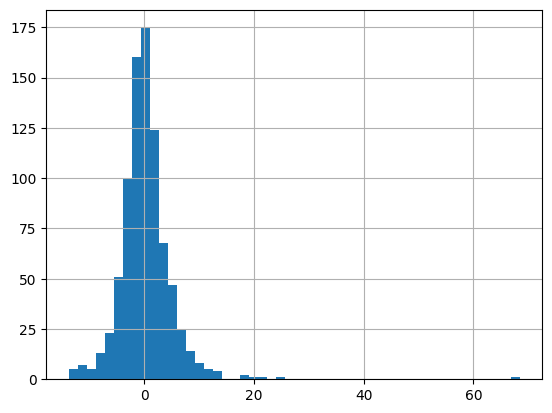

In [257]:
# 범위
result['수익률'].hist(bins=50)

<AxesSubplot: >

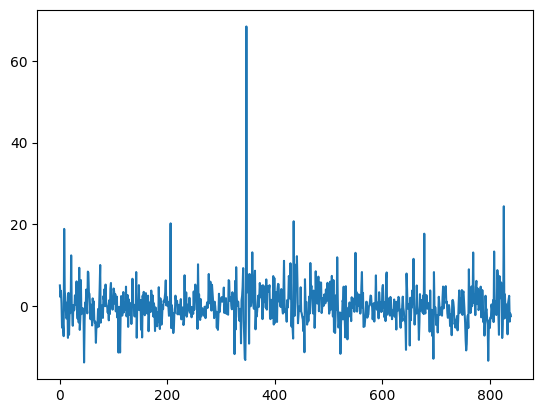

In [258]:
result['수익률'].plot()

In [262]:
#최고 최소 수익
print('최고수익',result['수익률'].max())
print('최저수익', result['수익률'].min())

최고수익 68.42105263157895
최저수익 -13.774973711882229


In [268]:
display(result[result['수익률']==result['수익률'].min()])
display(portfolio[portfolio['날짜']=='2018-05-18'])

,날짜,매수총합,매도총합,수익금,수익률
45,2018-05-18,47550,41000.0,-6550.0,-13.774974


,날짜,종가,시가,최고가,최저가,누적거래량,누적거래대금,종목명,5_mom,10_mom,20_mom,signal,5일후_종가
126431,2018-05-18,47550,46300,48100,45450,427400,20192142200,HL만도,108.314351,104.735683,103.369565,True,41000.0


In [273]:
display(result[result['수익률']==result['수익률'].max()])
display(portfolio[portfolio['날짜']=='2020-03-24'])

,날짜,매수총합,매도총합,수익금,수익률
347,2020-03-24,8550,14400.0,5850.0,68.421053


,날짜,종가,시가,최고가,최저가,누적거래량,누적거래대금,종목명,5_mom,10_mom,20_mom,signal,5일후_종가
568416,2020-03-24,8550,8730,8950,8330,16239692,140852688520,신풍제약,108.917197,108.778626,108.917197,True,14400.0


In [279]:
result['수익금'].sum()

91838.0